In [12]:
import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

labels = train['TARGET']
train.drop(['TARGET', 'ID'], axis=1, inplace=1)
test.drop(['ID'], axis=1, inplace=1)

### Зафиксируем разбиение выборки

In [4]:
from sklearn.cross_validation import cross_val_predict, StratifiedKFold

cv = StratifiedKFold(labels, n_folds=5, random_state=0)

Вставим небольшой костыль. Sklearn не умеет делать cross_val_predict для предсказания вероятностей

In [7]:
from sklearn.base import BaseEstimator

class ProbaEstimator(BaseEstimator):
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    
    def predict(self, X):
        return self.estimator.predict_proba(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

### Подготовим модели

Важно, чтобы разбиение оставалось фиксированным!

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
preds_rf = cross_val_predict(ProbaEstimator(rf), train, labels, cv=cv)
preds_test_rf = rf.fit(train, labels).predict_proba(test)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale

lr = LogisticRegression(C=1e-1)
preds_lr = cross_val_predict(ProbaEstimator(lr), scale(train), labels, cv=cv)
preds_test_lr = lr.fit(scale(train), labels).predict_proba(scale(test))

### Проверим качество отдельных классификаторов

In [14]:
from sklearn.metrics import roc_auc_score

print 'Random Forest: {0:0.3f}'.format(roc_auc_score(labels, preds_rf[:, 1]))
print 'Logistic Regression {0:0.3f}'.format(roc_auc_score(labels, preds_lr[:, 1]))

Random Forest: 0.749
Logistic Regression 0.792


### Стратегия 1: Blending

Best score: 0.805
Best alpha: 0.333


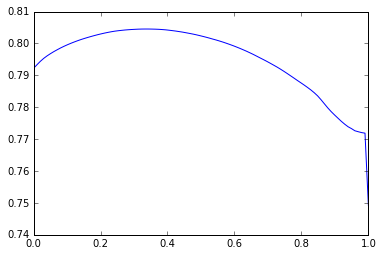

In [16]:
weights = np.linspace(0, 1, 100)
scores = np.zeros_like(weights)

for index, alpha in enumerate(weights):
    preds = alpha * preds_rf + (1-alpha) * preds_lr
    score = roc_auc_score(labels, preds[:, 1])
    scores[index] = score

plt.plot(weights, scores)
print 'Best score: {0:0.3f}'.format(scores.max())
print 'Best alpha: {0:0.3f}'.format(weights[scores.argmax()])

Посчитаем ответ!

In [17]:
alpha = 0.333
final_blending_prediction = alpha * preds_test_rf + (1-alpha) * preds_test_lr

### Стратегия 2: Stacking

In [32]:
from sklearn.cross_validation import cross_val_score

train_stacking = np.hstack([preds_rf, preds_lr])
test_stacking = np.hstack([preds_test_rf, preds_test_lr])

lr_stacking = LogisticRegression(C=1)
print cross_val_score(lr_stacking, train_stacking, labels, scoring='roc_auc', cv=cv).mean()

0.804407210801


Сделаем предсказание для теста!

In [33]:
final_stacking_prediction = lr_stacking.fit(train_stacking, labels).predict_proba(test_stacking)